<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/src/notebooks/image_pair_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate training pairs for a siamese neural network to detect identical cat faces.  Based on https://pyimagesearch.com/2020/11/23/building-image-pairs-for-siamese-networks-with-python/.  This post has a line-by-line explanation of the original code.  This notebook has been modified to use cat images generated by the `generate_transformed_images.ipynb` notebook rather than the MNIST numerical image dataset.


In [58]:
# import the necessary packages
from imutils import build_montages
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import cv2
import os
import zipfile


In [54]:
def make_pairs(images, labels):
	"""
	Make a train or test set for the siamese neural network by creating
	a set of image pairs and a corresponding set of labels which are
	either positive or negative.

	# Arguments
		images: list of images
		labels: list of labels
	# Returns
		tuple of (image pairs, pos/neg labels)
	"""
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []

  # Build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	idx = [np.where(labels == i)[0] for i in np.unique(labels)]
	# Create a dataframe whose index is the set of unique labels
	# and whose columns are the index values of images which belong
	# to that label.
	idx_df = pd.DataFrame(idx, index=np.unique(labels))

  # loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images.iloc[idxA]
		label = labels.iloc[idxA]
		# randomly pick an image that belongs to the *same* class
		# label
		indexes = idx_df.loc[label].values
		idxB = np.random.choice(indexes)
		posImage = images.iloc[idxB]
		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])
    # grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(np.unique(labels) != label)[0]
		negImage = images.iloc[np.random.choice(negIdx)]
		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])
	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [3]:
# IMG_SIZE and NUMBER_OF_TRANSFORMS must agree with the values in
# the `generate_transformed_images.ipynb` notebook.
IMG_SIZE = 244
NUMBER_OF_TRANSFORMS = 50
IMAGE_FOLDER = 'cat-face-transformed'
PATH_TO_READ = os.path.join('/content', IMAGE_FOLDER)

In [ ]:
# Be sure to upload `cat-face-transformed.zip` before running this cell.
!unzip cat-face-transformed.zip
!ls -1 ./cat-face-transformed | wc -l

In [64]:
df = pd.read_csv(os.path.join('/content', IMAGE_FOLDER + '.csv'))


In [10]:
def read_image(filename):
  return plt.imread(os.path.join('/content', IMAGE_FOLDER, filename))

In [39]:
def load_train_test_split(df):
  """
  Splits the data into training and testing sets.

  df is assumed to have the following structure:
  1. df.columns = [filename, label]
  2. Each filename of an original (not transformed) image is of the form 'imgNNN.jpg'
  3. df.label is a string which is the numeric part of the filename (as a string, not as an int)
  4. There are M transforms of each original.
  """
  # split the data into training and testing splits using 75% of
	# the data for training and the remaining 25% for testing
  labels = df['label'].unique()
  train_df = pd.DataFrame(columns=df.columns)
  test_df = pd.DataFrame(columns=df.columns)
  for i in range(len(labels)):
    label = labels[i]
    label_index = df.groupby('label').get_group(label).index.to_list()
    train_index = label_index[:int(len(label_index) * 0.75)]
    test_index = label_index[int(len(label_index) * 0.75):]
    train_df = pd.concat([train_df, df.iloc[train_index]])
    test_df = pd.concat([test_df, df.iloc[test_index]])
  return [train_df['filename'], train_df['label']], [test_df['filename'], test_df['label']]









In [40]:
# load cat-face-transformed dataset, consisting of 244x244 images of cats.
# The dataset has about 100 original images of cats amd 50 transforms of
# each original.
print("[INFO] loading cat-face-transformed dataset...")
(trainX, trainY), (testX, testY) = load_train_test_split(df)

[INFO] loading cat-face-transformed dataset...


[INFO] preparing positive and negative pairs...


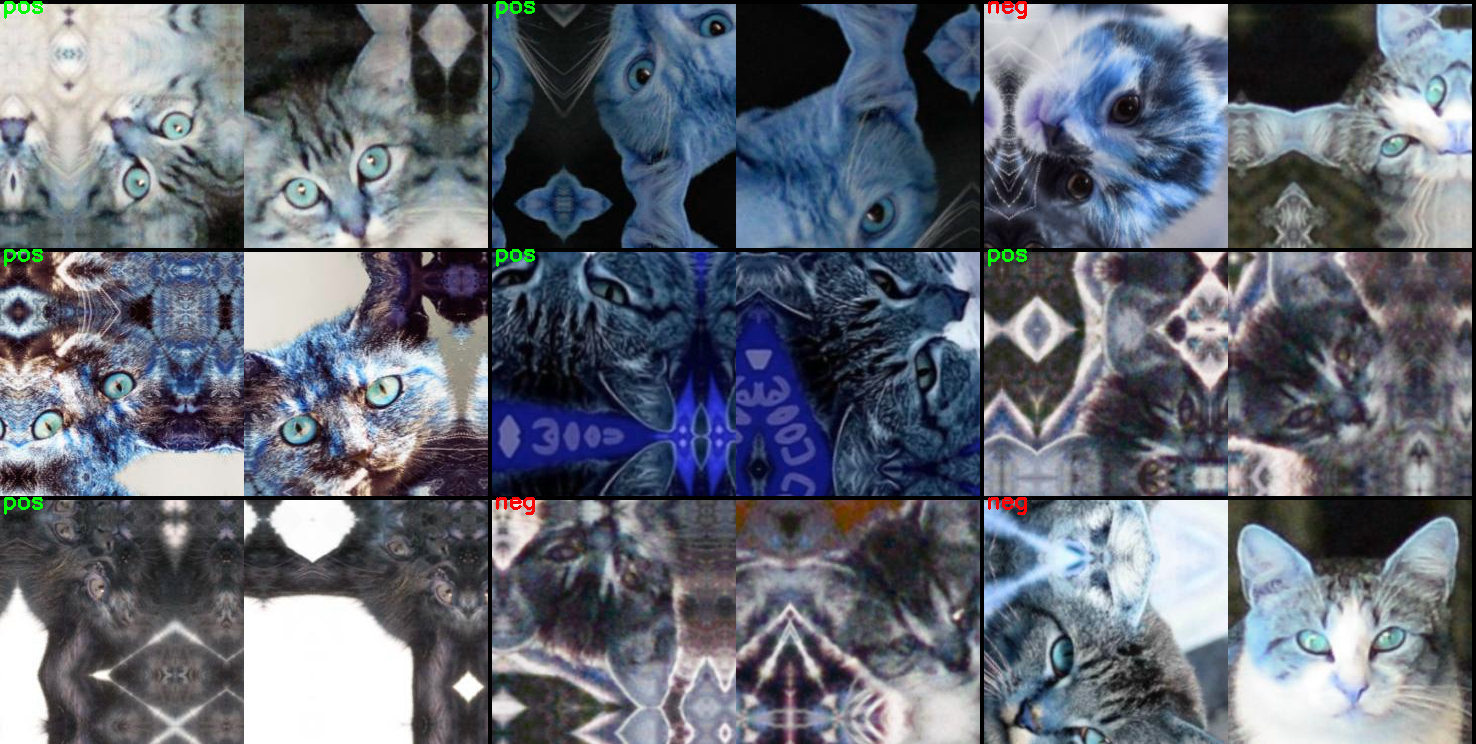

-1

In [63]:
# build the positive and negative image pairs
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)
# initialize the list of images that will be used when building our
# montage
images = []
# loop over a sample of our training pairs
for i in np.random.choice(np.arange(0, len(pairTrain)), size=(49,)):
	# grab the current image pair and label
	imageA = read_image(pairTrain[i][0])
	imageB = read_image(pairTrain[i][1])
	label = labelTrain[i]
	# to make it easier to visualize the pairs and their positive or
	# negative annotations, we're going to "pad" the pair with four
	# pixels along the top, bottom, and right borders, respectively
	output = np.zeros((248, 492, 3), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	output[4:248, 0:488, 0:3] = pair
	# set the text label for the pair along with what color we are
	# going to draw the pair in (green for a "positive" pair and
	# red for a "negative" pair)
	text = "neg" if label[0] == 0 else "pos"
	color = (0, 0, 255) if label[0] == 0 else (0, 255, 0)
	# draw what type of pair it is on the image
	cv2.putText(output, text, (2, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
	 	color, 2)
	# add the pair visualization to our list of output images
	images.append(output)
# construct the montage for the images
montage = build_montages(images, (492, 248), (3,3))[0]
# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)